# **Drive Failure Prediction Using Machine Learning**

In [ ]:
!pip install ydata-profiling

# **Step0 : Libraries**

In [69]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
# from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter


 ## **Step 1: Load and Inspect the Dataset**

### We begin by importing the datasets and performing initial inspection to understand the structure and check for null values, datatypes, and class distribution.


In [70]:
# Extracts all files from the provided ZIP archive into a temporary folder.
zip_path = '/content/1.zip'


extract_path = '/content/clean_data_unzipped'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Recursively walks through the extracted directory and stores paths of all .csv files found.
csv_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found {len(csv_files)} CSV files")


if len(csv_files) == 0:
    raise ValueError("No CSV files found inside the zip!")

# Reads each CSV file and merges them into one single Pandas DataFrame for unified processing.
combined_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# Exports the merged dataset to a CSV file and previews the top 5 rows for verification.
output_path = '/content/combined_clean_data.csv'
combined_df.to_csv(output_path, index=False)

print(f"Combined CSV saved to: {output_path}")
combined_df.head()


Found 82 CSV files
Combined CSV saved to: /content/combined_clean_data.csv


,Cluster,ID,SOFT_ERRORS,HARD_ERRORS,TRANSPORT_ERRORS,VENDOR,PRODUCT,REVISION,SERIAL_NUMBER,MEDIA_ERROR,...,ECC_DELAYED_VERIFY,EC_BY_REREADS_WRITES_VERIFY,TOTAL_ERRORS_CORRECTED_VERIFY,CORRECTION_ALGORITHM_INVOCATIONS_VERIFY,GIGABYTES_PROCESSED_VERIFY,DISCONNECT_PATH_1,TIMEOUT_PATH_1,DISCONNECT_PATH_2,TIMEOUT_PATH_2,PARSE_STATUS
0,nstorhsb18,c0t5000CCA2DF82BBACd0,0,0,0,HGST,HUH721212AL5200,AB01,D7J9WVKN,0,...,0.0,0.0,0.0,415.0,0.0,0,0,0,0,OK
1,nstoremc,c0t5000CCA26C228BC4d0,0,0,0,HGST,HUH721010AL4200,A38F,1DGLZZ3Z,0,...,0.0,0.0,0.0,426681.0,0.0,0,0,0,0,OK
2,nstoremc,c0t5000CCA26C215004d0,0,0,0,HGST,HUH721010AL4200,A38F,1DGL9Y7Z,0,...,0.0,0.0,0.0,490809.0,0.0,0,0,0,0,OK
3,nstorhsb18,c0t5000CCA2DF81A8A4d0,0,0,0,HGST,HUH721212AL5200,AB01,D7J99JSN,0,...,0.0,0.0,0.0,1217.0,0.0,0,0,0,0,OK
4,nstorhsb18,c0t5000CCA2DF82A2BCd0,0,0,0,HGST,HUH721212AL5200,AB01,D7J9V62N,0,...,0.0,0.0,0.0,348.0,0.0,0,0,0,0,OK


In [71]:
combined_df.shape

(74091, 49)

Vendor counts:
VENDOR
HGST       73271
TOSHIBA      492
ATA          328
Name: count, dtype: int64


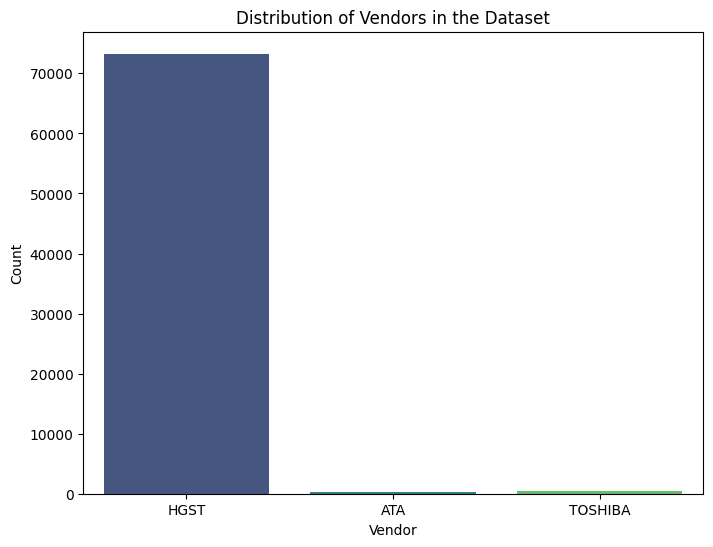

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print the vendor counts
print("Vendor counts:")
print(combined_df['VENDOR'].value_counts())

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='VENDOR', data=combined_df, palette='viridis', hue='VENDOR', legend=False)
plt.title('Distribution of Vendors in the Dataset')
plt.xlabel('Vendor')
plt.ylabel('Count')
plt.show()

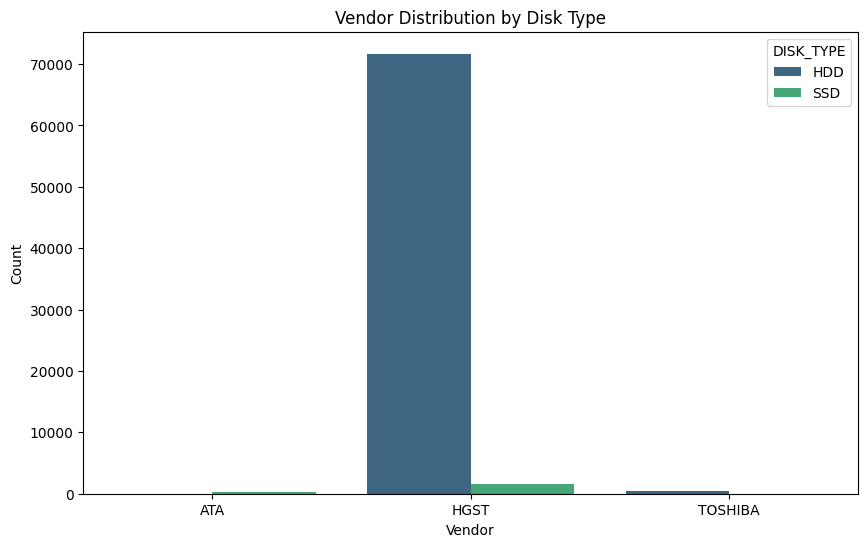

In [73]:
# Calculate vendor counts by disk type
vendor_disk_type_counts = combined_df.groupby(['DISK_TYPE', 'VENDOR']).size().reset_index(name='Count')

# Plot the vendor distribution by disk type
plt.figure(figsize=(10, 6))
sns.barplot(x='VENDOR', y='Count', hue='DISK_TYPE', data=vendor_disk_type_counts, palette='viridis')
plt.title('Vendor Distribution by Disk Type')
plt.xlabel('Vendor')
plt.ylabel('Count')
plt.show()

Error Type Breakdown by Vendor and Disk Type:


SOFT_ERRORS  HARD_ERRORS  TRANSPORT_ERRORS  MEDIA_ERROR  \
VENDOR  DISK_TYPE                                                            
ATA     HDD                  0            0                 0            0   
        SSD                  0            0                 0            0   
HGST    HDD                  0        34832             11317          328   
        SSD                  0         2646                82            0   
TOSHIBA HDD                  0            0                 0            0   

                   DEVICE_NOT_READY  NO_DEVICE  RECOVERABLE  ILLEGAL_REQUEST  \
VENDOR  DISK_TYPE                                                              
ATA     HDD                       0          0            0             4896   
        SSD                       0          0            0           948466   
HGST    HDD                      82      34422            0                0   
        SSD                       0       2646            0                0   
TOSHIBA HDD                       0          0            0                0   

                   PREDICTIVE_FAILURE_ANALYSIS  
VENDOR  DISK_TYPE                               
ATA     HDD                                  0  
        SSD                                  0  
HGST    HDD                                  0  
        SSD                                  0  
TOSHIBA HDD                                  0

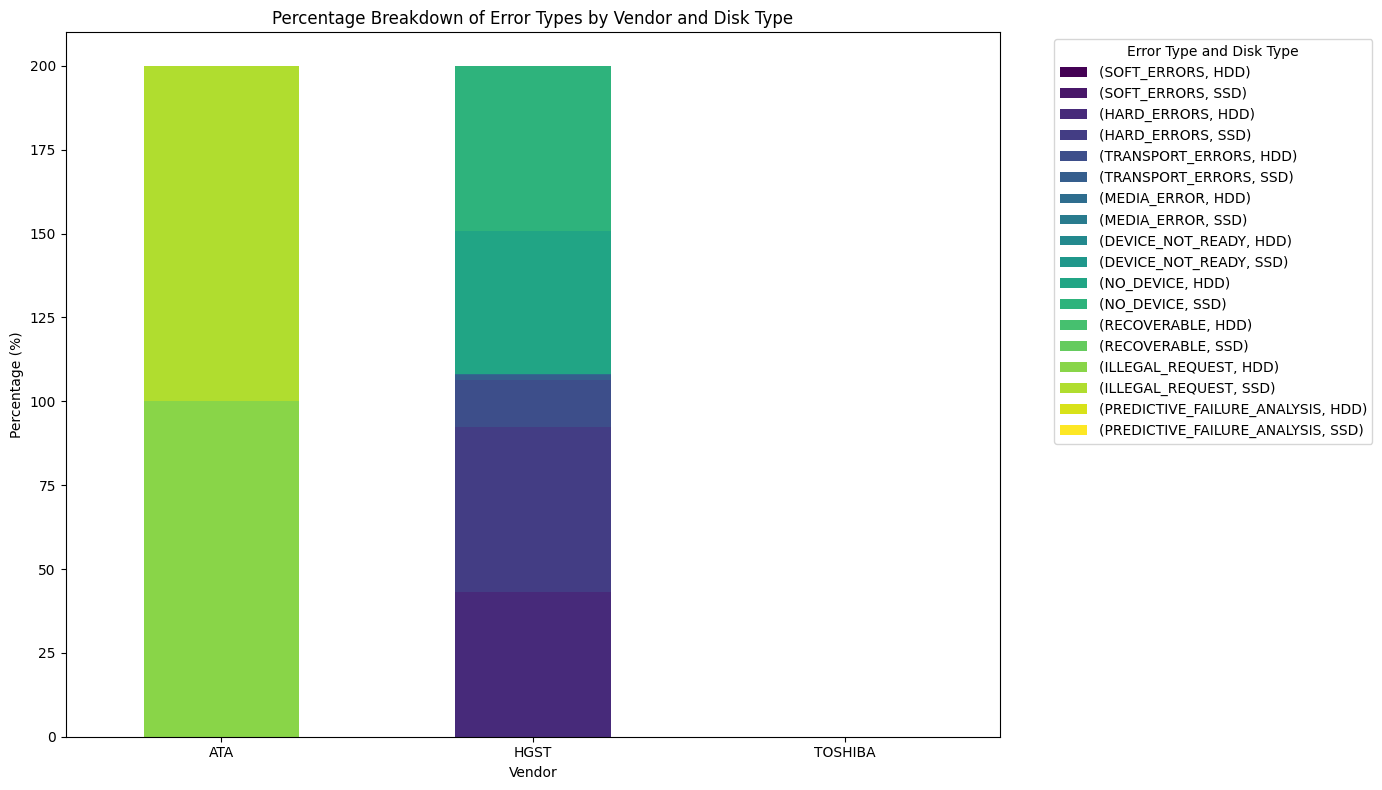

In [74]:
# Select relevant error columns
error_cols = [
    'SOFT_ERRORS', 'HARD_ERRORS', 'TRANSPORT_ERRORS', 'MEDIA_ERROR',
    'DEVICE_NOT_READY', 'NO_DEVICE', 'RECOVERABLE', 'ILLEGAL_REQUEST',
    'PREDICTIVE_FAILURE_ANALYSIS'
]

# Filter for existing error columns in combined_df
existing_error_cols = [col for col in error_cols if col in combined_df.columns]

if existing_error_cols:
    # Calculate the total errors for each vendor and disk type across selected error columns
    vendor_disk_type_errors = combined_df.groupby(['VENDOR', 'DISK_TYPE'])[existing_error_cols].sum()

    # Print the breakdown of error types per vendor and disk type
    print("Error Type Breakdown by Vendor and Disk Type:")
    display(vendor_disk_type_errors)

    # Plot the breakdown of error types per vendor and disk type as a stacked bar chart
    vendor_disk_type_errors_percentage = vendor_disk_type_errors.divide(vendor_disk_type_errors.sum(axis=1), axis=0) * 100

    # Unstack the DataFrame for plotting
    vendor_disk_type_errors_percentage_unstacked = vendor_disk_type_errors_percentage.unstack(level='DISK_TYPE')

    plt.figure(figsize=(14, 8))
    vendor_disk_type_errors_percentage_unstacked.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
    plt.title('Percentage Breakdown of Error Types by Vendor and Disk Type')
    plt.xlabel('Vendor')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Error Type and Disk Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("No relevant error columns found to plot.")

## **Step 2: Data Cleaning and Preprocessing**

We clean the data by removing irrelevant columns, handling missing values, and encoding categorical variables. We also normalize numerical features to ensure fair contribution across features.


### We now clean the dataset by removing irrelevant columns, handling missing values, and creating a new target variable **WILL_FAIL** based on domain-specific logic. We also split the data into **SSD** and **HDD** subsets for separate analysis

This logic defines a drive failure (WILL_FAIL = 1) if any of the following conditions are true:

* It has hard, media, or device errors.

* Predictive failure analysis has been triggered.

* All timeout and disconnect paths are active (suggesting a communication breakdown).

* The current temperature is dangerously close to the trip threshold (within 10°C of 60°C or higher).

The resulting WILL_FAIL column is binary:

* 1 → Drive likely to fail.

* 0 → Drive operating normally.

In [75]:
# A list of key columns used to determine whether a drive is likely to fail. These are common indicators of hardware issues.
required_cols = [
    'HARD_ERRORS', 'MEDIA_ERROR', 'DEVICE_NOT_READY', 'NO_DEVICE',
    'PREDICTIVE_FAILURE_ANALYSIS', 'TIMEOUT_PATH_1', 'TIMEOUT_PATH_2',
    'DISCONNECT_PATH_1', 'DISCONNECT_PATH_2', 'CURRENT_DRIVE_TEMPERATURE', 'DRIVE_TRIP_TEMPERATURE'
]


if all(col in combined_df.columns for col in required_cols):

    combined_df['TEMP_MARGIN'] = combined_df['DRIVE_TRIP_TEMPERATURE'] - combined_df['CURRENT_DRIVE_TEMPERATURE']

    combined_df['WILL_FAIL'] = (
        (combined_df['HARD_ERRORS'] > 0) |
        (combined_df['MEDIA_ERROR'] > 0) |
        (combined_df['DEVICE_NOT_READY'] > 0) |
        (combined_df['NO_DEVICE'] > 0) |
        (combined_df['PREDICTIVE_FAILURE_ANALYSIS'] > 0) |
        (
            (combined_df['TIMEOUT_PATH_1'] == 1) &
            (combined_df['TIMEOUT_PATH_2'] == 1) &
            (combined_df['DISCONNECT_PATH_1'] == 1) &
            (combined_df['DISCONNECT_PATH_2'] == 1)
        ) |
        (
            (combined_df['CURRENT_DRIVE_TEMPERATURE'] >= 60) &
            ((combined_df['DRIVE_TRIP_TEMPERATURE'] - combined_df['CURRENT_DRIVE_TEMPERATURE']) <= 10)
        )
    ).astype(int)

    print("WILL_FAIL' successfully defined using  logic.")
    print(combined_df['WILL_FAIL'].value_counts())
else:
    missing = [col for col in required_cols if col not in combined_df.columns]
    raise KeyError(f"Missing required columns: {missing}")





WILL_FAIL' successfully defined using  logic.
WILL_FAIL
0    63012
1    11079
Name: count, dtype: int64


## About 15% of drives are marked as at-risk, confirming a class imbalance that will need to be addressed (e.g. via SMOTE or class weights).

In [76]:
print("Unique Disk Types:\n", combined_df["DISK_TYPE"].unique())
print("Vendor counts by disk type:\n", combined_df.groupby("DISK_TYPE")["VENDOR"].value_counts())
ssd_df = combined_df[combined_df["DISK_TYPE"] == "SSD"].copy()
hdd_df = combined_df[combined_df["DISK_TYPE"] == "HDD"].copy()


Unique Disk Types:
 ['HDD' 'SSD']
Vendor counts by disk type:
 DISK_TYPE  VENDOR 
HDD        HGST       71679
           TOSHIBA      492
           ATA           16
SSD        HGST        1592
           ATA          312
Name: count, dtype: int64


### Vendor Distribution by Disk Type

The dataset shows the following vendor breakdown:

#### HDD:
- **HGST**: 71,679 drives
- **TOSHIBA**: 492 drives
- **ATA**: 16 drives

#### SSD:
- **HGST**: 1,592 drives
- **ATA**: 312 drives

This indicates that:
- **HGST** is the dominant vendor for both HDDs and SSDs.
- Other vendors like **TOSHIBA** and **ATA** have minor representation.
- The dataset lacks diversity in vendor representation, especially for SSDs.


## HGST drives show consistent risk across drive types and should be analyzed further for root causes (temperature, usage hours, etc.).

In [77]:
print("\n Failure Rate by Vendor:")
print(combined_df.groupby(['VENDOR','DISK_TYPE'])['WILL_FAIL'].mean())


 Failure Rate by Vendor:
VENDOR   DISK_TYPE
ATA      HDD          0.000000
         SSD          0.000000
HGST     HDD          0.152276
         SSD          0.103015
TOSHIBA  HDD          0.000000
Name: WILL_FAIL, dtype: float64


In [78]:
print(f"SSD shape: {ssd_df.shape}")
print(f"HDD shape: {hdd_df.shape}")

SSD shape: (1904, 51)
HDD shape: (72187, 51)


# This highlights a vendor imbalance: HDDs are more diverse but skewed heavily toward HGST, while SSDs are more concentrated.
# Class imbalance exists, which will need to be addressed via SMOTE, class_weight, or similar techniques during modeling.

In [79]:
hdd_df.head()

,Cluster,ID,SOFT_ERRORS,HARD_ERRORS,TRANSPORT_ERRORS,VENDOR,PRODUCT,REVISION,SERIAL_NUMBER,MEDIA_ERROR,...,TOTAL_ERRORS_CORRECTED_VERIFY,CORRECTION_ALGORITHM_INVOCATIONS_VERIFY,GIGABYTES_PROCESSED_VERIFY,DISCONNECT_PATH_1,TIMEOUT_PATH_1,DISCONNECT_PATH_2,TIMEOUT_PATH_2,PARSE_STATUS,TEMP_MARGIN,WILL_FAIL
0,nstorhsb18,c0t5000CCA2DF82BBACd0,0,0,0,HGST,HUH721212AL5200,AB01,D7J9WVKN,0,...,0.0,415.0,0.0,0,0,0,0,OK,43.0,0
1,nstoremc,c0t5000CCA26C228BC4d0,0,0,0,HGST,HUH721010AL4200,A38F,1DGLZZ3Z,0,...,0.0,426681.0,0.0,0,0,0,0,OK,53.0,0
2,nstoremc,c0t5000CCA26C215004d0,0,0,0,HGST,HUH721010AL4200,A38F,1DGL9Y7Z,0,...,0.0,490809.0,0.0,0,0,0,0,OK,44.0,0
3,nstorhsb18,c0t5000CCA2DF81A8A4d0,0,0,0,HGST,HUH721212AL5200,AB01,D7J99JSN,0,...,0.0,1217.0,0.0,0,0,0,0,OK,42.0,0
4,nstorhsb18,c0t5000CCA2DF82A2BCd0,0,0,0,HGST,HUH721212AL5200,AB01,D7J9V62N,0,...,0.0,348.0,0.0,0,0,0,0,OK,52.0,0


# Both SSD and HDD datasets contain multiple columns with significant missing values.

 # Some columns have over 50% nulls and are candidates for dropping.

In [80]:
print("Nulls in SSD:")
print(ssd_df.isnull().sum()[ssd_df.isnull().sum() > 0])

print("\nNulls in HDD:")
print(hdd_df.isnull().sum()[hdd_df.isnull().sum() > 0])

Nulls in SSD:
MANUFACTURED                                312
START_STOP_CYCLES                           312
SPECIFIED_CYCLE_LIFETIME                    312
LOAD_UNLOAD_CYCLES                          558
SPECIFIED_LOAD_UNLOAD_LIFETIME              558
ECC_FAST_WRITE                              312
ECC_DELAYED_WRITE                           312
EC_BY_REREADS_WRITES_WRITE                  312
TOTAL_ERRORS_CORRECTED_WRITE                312
CORRECTION_ALGORITHM_INVOCATIONS_WRITE      312
GIGABYTES_PROCESSED_WRITE                   312
ECC_FAST_VERIFY                            1658
ECC_DELAYED_VERIFY                         1658
EC_BY_REREADS_WRITES_VERIFY                1658
TOTAL_ERRORS_CORRECTED_VERIFY              1658
CORRECTION_ALGORITHM_INVOCATIONS_VERIFY    1658
GIGABYTES_PROCESSED_VERIFY                 1658
dtype: int64

Nulls in HDD:
TIMESTAMP                                  272
MANUFACTURED                               272
CURRENT_DRIVE_TEMPERATURE                  272
S

#['ECC_FAST_VERIFY', 'ECC_DELAYED_VERIFY', 'EC_BY_REREADS_WRITES_VERIFY', 'TOTAL_ERRORS_CORRECTED_VERIFY', 'CORRECTION_ALGORITHM_INVOCATIONS_VERIFY', 'GIGABYTES_PROCESSED_VERIFY']


#These columns add noise due to sparsity and are excluded from further analysis.

In [81]:

threshold = 0.5
null_ratios = ssd_df.isnull().mean()
cols_to_drop = null_ratios[null_ratios > threshold].index

print("Dropping these columns from SSD (null > 50%):")
print(cols_to_drop.tolist())

ssd_df = ssd_df.drop(columns=cols_to_drop)


Dropping these columns from SSD (null > 50%):
['ECC_FAST_VERIFY', 'ECC_DELAYED_VERIFY', 'EC_BY_REREADS_WRITES_VERIFY', 'TOTAL_ERRORS_CORRECTED_VERIFY', 'CORRECTION_ALGORITHM_INVOCATIONS_VERIFY', 'GIGABYTES_PROCESSED_VERIFY']


In [82]:
print("Nulls in SSD:")
print(ssd_df.isnull().sum())

Nulls in SSD:
Cluster                                     0
ID                                          0
SOFT_ERRORS                                 0
HARD_ERRORS                                 0
TRANSPORT_ERRORS                            0
VENDOR                                      0
PRODUCT                                     0
REVISION                                    0
SERIAL_NUMBER                               0
MEDIA_ERROR                                 0
DEVICE_NOT_READY                            0
NO_DEVICE                                   0
RECOVERABLE                                 0
ILLEGAL_REQUEST                             0
PREDICTIVE_FAILURE_ANALYSIS                 0
SIZE_BYTES                                  0
TIMESTAMP                                   0
MANUFACTURED                              312
CURRENT_DRIVE_TEMPERATURE                   0
ENDURANCE                                   0
DISK_TYPE                                   0
START_STOP_CYCLES   

# In small datasets like SSD, it's often better to retain features and use imputation, even if it's a rough estimate, rather than risk losing signal by dropping many columns.

In [83]:
# Fill remaining nulls in SSD with mode (most frequent value)
for col in ssd_df.columns:
    if ssd_df[col].isnull().sum() > 0:
        mode_value = ssd_df[col].mode()[0]
        ssd_df[col].fillna(mode_value, inplace=True)

print("Nulls in SSD:")
print(ssd_df.isnull().sum())


Nulls in SSD:
Cluster                                   0
ID                                        0
SOFT_ERRORS                               0
HARD_ERRORS                               0
TRANSPORT_ERRORS                          0
VENDOR                                    0
PRODUCT                                   0
REVISION                                  0
SERIAL_NUMBER                             0
MEDIA_ERROR                               0
DEVICE_NOT_READY                          0
NO_DEVICE                                 0
RECOVERABLE                               0
ILLEGAL_REQUEST                           0
PREDICTIVE_FAILURE_ANALYSIS               0
SIZE_BYTES                                0
TIMESTAMP                                 0
MANUFACTURED                              0
CURRENT_DRIVE_TEMPERATURE                 0
ENDURANCE                                 0
DISK_TYPE                                 0
START_STOP_CYCLES                         0
SPECIFIED_CYCLE_LI

/tmp/ipython-input-981291283.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ssd_df[col].fillna(mode_value, inplace=True)


#**Rationale:**
#We removed the above columns for the following reasons:

#'**ID', 'SERIAL_NUMBER':** Unique identifiers with no predictive power; they only add noise.

#**'REVISION', 'PRODUCT':** Hardware metadata that doesn't carry meaningful signal for failure prediction in our modeling context.

#**'TIMESTAMP', 'MANUFACTURED':** Time-based features were dropped intentionally because:

#Our models are not temporal (no time-series modeling involved).

#We assume failure patterns are captured by SMART metrics, not timestamp progression.

#**'DISK_TYPE':** Already split into separate datasets (ssd_df and hdd_df), so the column is now redundant.

#Columns with only one unique value were also removed with .nunique() > 1 filter.

#* Note: Time features like MANUFACTURED or TIMESTAMP could be useful in survival analysis or time-to-failure prediction, but not in our current binary classification setup.

In [84]:
columns_to_drop = [
    'ID', 'SERIAL_NUMBER', 'REVISION', 'PRODUCT',
    'TIMESTAMP', 'MANUFACTURED', 'DISK_TYPE'
]

def drop_cols(df):
    df = df.drop(columns=columns_to_drop, errors='ignore')
    df = df.loc[:, df.nunique() > 1]
    return df

ssd_df = drop_cols(ssd_df)
hdd_df = drop_cols(hdd_df)



# Duplicate


In [85]:
hdd_df.shape

(72187, 29)

In [86]:
hdd_df.drop_duplicates(inplace=True)
hdd_df.shape

(62658, 29)

In [87]:
ssd_df.shape

(1904, 15)

In [88]:

ssd_df.drop_duplicates(inplace=True)
ssd_df.shape

(1194, 15)

# To understand the class balance in our binary classification task, we visualized the distribution of the WILL_FAIL variable for both SSD and HDD datasets.

WILL_FAIL
0    1034
1     160
Name: count, dtype: int64


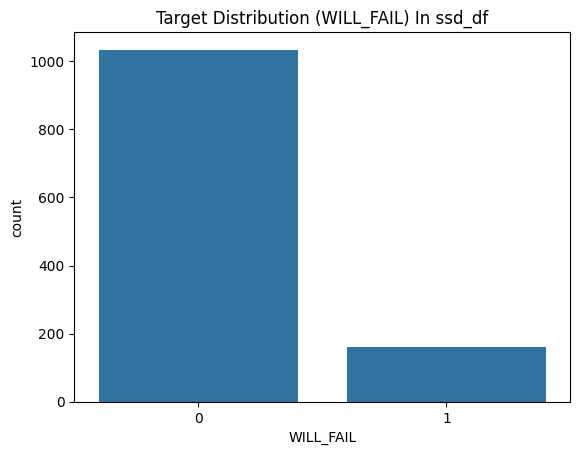

In [89]:
print(ssd_df['WILL_FAIL'].value_counts())
sns.countplot(x='WILL_FAIL', data=ssd_df)
plt.title("Target Distribution (WILL_FAIL) In ssd_df")
plt.show()


# Only **8.4%** of SSDs failed.
# This indicates a moderate class imbalance, but not extreme. SMOTE or class weights may help during model training.

In [90]:
hdd_df = hdd_df.dropna()

WILL_FAIL
0    52298
1    10110
Name: count, dtype: int64


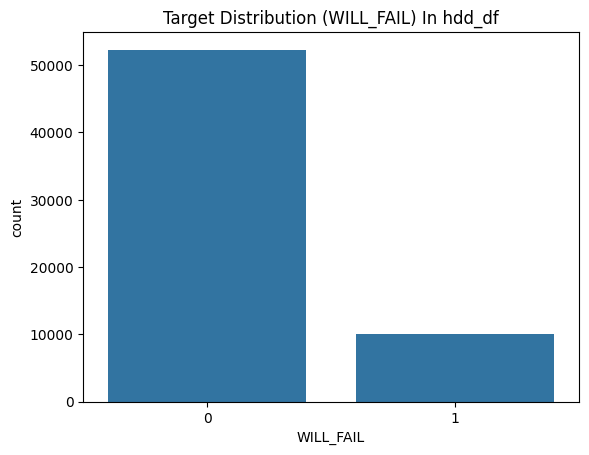

In [91]:
print(hdd_df['WILL_FAIL'].value_counts())
sns.countplot(x='WILL_FAIL', data=hdd_df)
plt.title("Target Distribution (WILL_FAIL) In hdd_df")
plt.show()

# About **14.4%** of HDDs experienced failure.
# Still imbalanced, but with more failure samples than SSDs, which can help model learning.

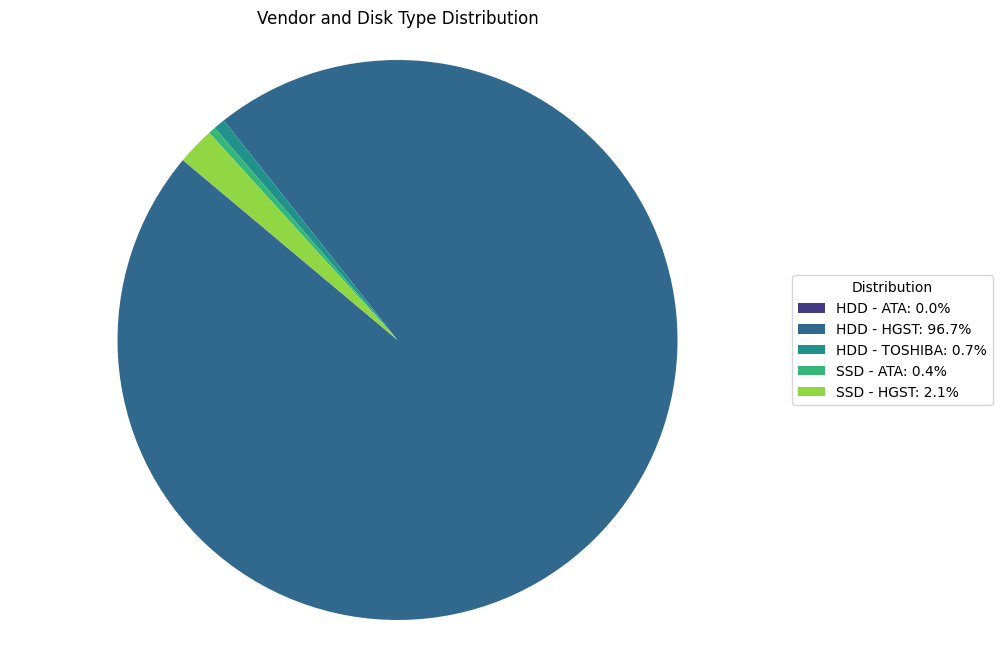

In [92]:
vendor_disk_type_counts = combined_df.groupby(['DISK_TYPE', 'VENDOR']).size().reset_index(name='Count')

# Create labels for the pie chart
vendor_disk_type_counts['Label'] = vendor_disk_type_counts['DISK_TYPE'] + ' - ' + vendor_disk_type_counts['VENDOR']

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(vendor_disk_type_counts['Count'], labels=None, startangle=140, colors=sns.color_palette('viridis', len(vendor_disk_type_counts)))
plt.title('Vendor and Disk Type Distribution')
plt.axis('equal')


total = vendor_disk_type_counts['Count'].sum()
legend_labels = [f'{label}: {count/total:.1%}' for label, count in zip(vendor_disk_type_counts['Label'], vendor_disk_type_counts['Count'])]
plt.legend(legend_labels, title="Distribution", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [93]:
vendor_disk_type_counts = combined_df.groupby(['DISK_TYPE', 'VENDOR']).size()
vendor_disk_type_counts

DISK_TYPE  VENDOR 
HDD        ATA           16
           HGST       71679
           TOSHIBA      492
SSD        ATA          312
           HGST        1592
dtype: int64

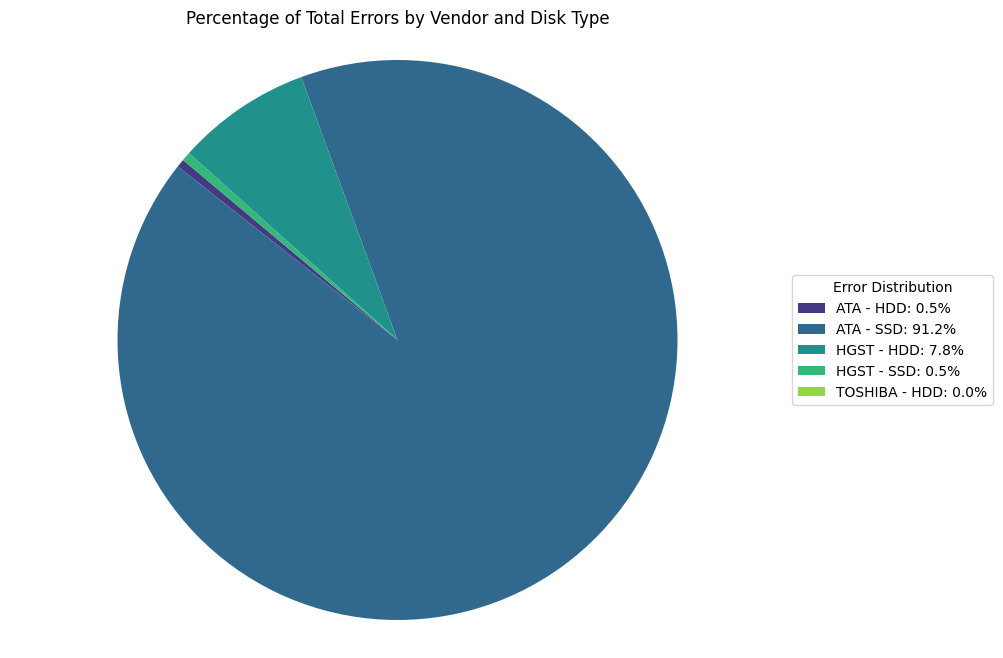

In [94]:
# Select relevant error columns
error_cols = [
    'SOFT_ERRORS', 'HARD_ERRORS', 'TRANSPORT_ERRORS', 'MEDIA_ERROR',
    'DEVICE_NOT_READY', 'NO_DEVICE', 'RECOVERABLE', 'ILLEGAL_REQUEST',
    'PREDICTIVE_FAILURE_ANALYSIS'
]

# Filter for existing error columns in combined_df
existing_error_cols = [col for col in error_cols if col in combined_df.columns]

if existing_error_cols:
    # Calculate the total errors for each vendor and disk type across selected error columns
    vendor_disk_type_errors = combined_df.groupby(['VENDOR', 'DISK_TYPE'])[existing_error_cols].sum().sum(axis=1)

    # Calculate the total errors across all vendors and disk types
    total_errors = vendor_disk_type_errors.sum()

    # Calculate percentage of total errors per vendor and disk type combination
    vendor_disk_type_error_percentage = (vendor_disk_type_errors / total_errors) * 100

    # Create labels for the pie chart
    labels = [f'{vendor} - {disk_type}' for vendor, disk_type in vendor_disk_type_error_percentage.index]

    # Create the pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(vendor_disk_type_error_percentage.values, labels=None, startangle=140, colors=sns.color_palette('viridis', len(vendor_disk_type_error_percentage)))
    plt.title('Percentage of Total Errors by Vendor and Disk Type')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Add a legend with labels and percentages
    legend_labels = [f'{label}: {percentage:.1f}%' for label, percentage in zip(labels, vendor_disk_type_error_percentage.values)]
    plt.legend(legend_labels, title="Error Distribution", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


    plt.show()

else:
    print("No relevant error columns found to plot.")

Vendor counts by Disk Type:


,DISK_TYPE,VENDOR,Count
0,HDD,ATA,16
1,HDD,HGST,71679
2,HDD,TOSHIBA,492
3,SSD,ATA,312
4,SSD,HGST,1592


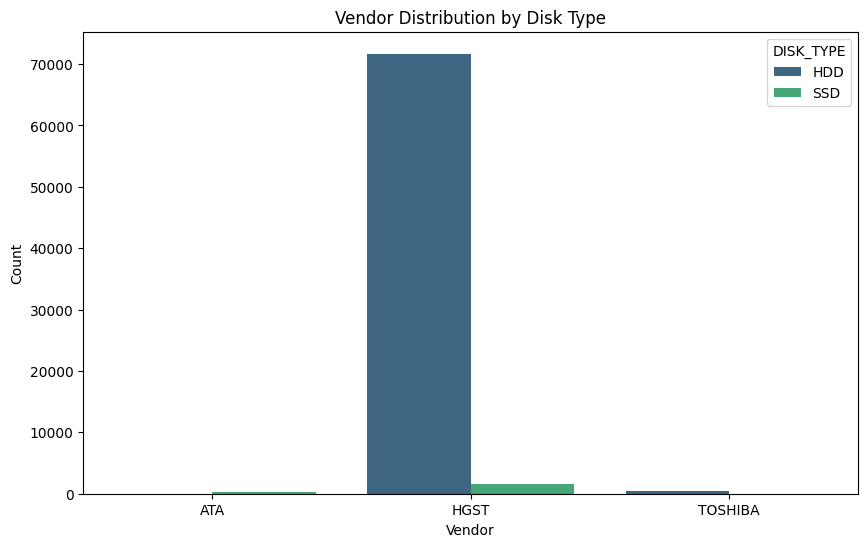

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate vendor counts by disk type and display as a table
vendor_disk_type_counts = combined_df.groupby(['DISK_TYPE', 'VENDOR']).size().reset_index(name='Count')
print("Vendor counts by Disk Type:")
display(vendor_disk_type_counts)

# Plot the vendor distribution by disk type as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='VENDOR', y='Count', hue='DISK_TYPE', data=vendor_disk_type_counts, palette='viridis')
plt.title('Vendor Distribution by Disk Type')
plt.xlabel('Vendor')
plt.ylabel('Count')
plt.show()

Error Type Breakdown by Disk Type:


,SOFT_ERRORS,HARD_ERRORS,TRANSPORT_ERRORS,MEDIA_ERROR,DEVICE_NOT_READY,NO_DEVICE,RECOVERABLE,ILLEGAL_REQUEST,PREDICTIVE_FAILURE_ANALYSIS
DISK_TYPE,,,,,,,,,
HDD,0,34832,11317,328,82,34422,0,4896,0
SSD,0,2646,82,0,0,2646,0,948466,0


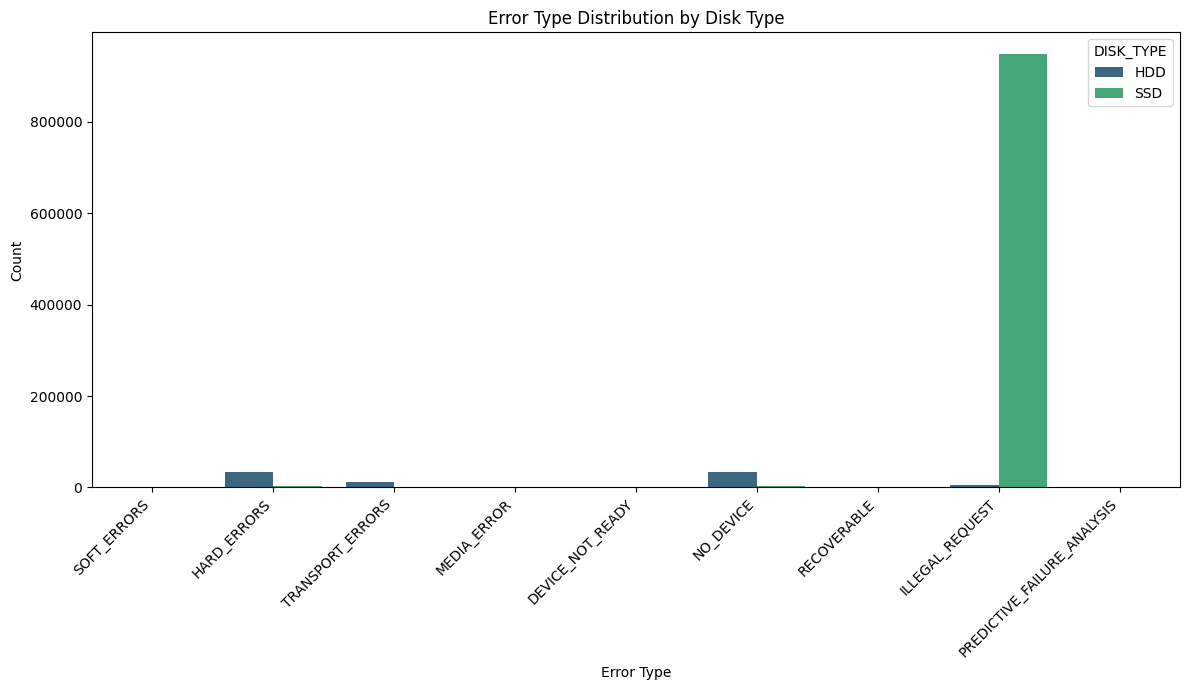

In [96]:
# Select relevant error columns
error_cols = [
    'SOFT_ERRORS', 'HARD_ERRORS', 'TRANSPORT_ERRORS', 'MEDIA_ERROR',
    'DEVICE_NOT_READY', 'NO_DEVICE', 'RECOVERABLE', 'ILLEGAL_REQUEST',
    'PREDICTIVE_FAILURE_ANALYSIS'
]

# Filter for existing error columns in combined_df
existing_error_cols = [col for col in error_cols if col in combined_df.columns]

if existing_error_cols:
    # Calculate the total errors for each disk type across selected error columns
    disk_type_errors = combined_df.groupby('DISK_TYPE')[existing_error_cols].sum()

    # Print the breakdown of error types per disk type
    print("Error Type Breakdown by Disk Type:")
    display(disk_type_errors)

    # Reshape the DataFrame for plotting (unstack or melt)
    disk_type_errors_stacked = disk_type_errors.stack().reset_index(name='Count')
    disk_type_errors_stacked.rename(columns={'level_1': 'Error_Type'}, inplace=True)

    # Plot the error distribution by disk type
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Error_Type', y='Count', hue='DISK_TYPE', data=disk_type_errors_stacked, palette='viridis')
    plt.title('Error Type Distribution by Disk Type')
    plt.xlabel('Error Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout()
    plt.show()

else:
    print("No relevant error columns found to display.")

In [97]:
print("Value counts for columns in SSD:")
for i in ssd_df.columns:
    print(f"Column: {i}")
    print(ssd_df[i].value_counts(dropna=False))
    print("-" * 30)

print("\nValue counts for columns in HDD:")
for i in hdd_df.columns:  # Iterate over columns of hdd_df
    print(f"Column: {i}")
    print(hdd_df[i].value_counts(dropna=False))
    print("-" * 30)

Value counts for columns in SSD:
Column: Cluster
Cluster
nstorhsb18    817
nstoremc      377
Name: count, dtype: int64
------------------------------
Column: HARD_ERRORS
HARD_ERRORS
0     1034
4       80
27      34
30      26
29      17
22       2
26       1
Name: count, dtype: int64
------------------------------
Column: TRANSPORT_ERRORS
TRANSPORT_ERRORS
0    1151
1      43
Name: count, dtype: int64
------------------------------
Column: VENDOR
VENDOR
HGST    1018
ATA      176
Name: count, dtype: int64
------------------------------
Column: NO_DEVICE
NO_DEVICE
0     1034
4       80
27      34
30      26
29      17
22       2
26       1
Name: count, dtype: int64
------------------------------
Column: ILLEGAL_REQUEST
ILLEGAL_REQUEST
0       1018
3541       2
3493       2
3929       2
3817       2
        ... 
330        1
366        1
3657       1
3553       1
314        1
Name: count, Length: 149, dtype: int64
------------------------------
Column: SIZE_BYTES
SIZE_BYTES
100030242816   

# Cluster & VENDOR: Each dataset has 2–3 main Cluster and VENDOR values, with HGST dominating both SSD and HDD.

#WILL_FAIL: Failure is rare but present (~8.6% SSD, ~15% HDD), confirming class imbalance.

#Errors (HARD_ERRORS, TRANSPORT_ERRORS, NO_DEVICE): Most values are 0, but HDDs show more diversity and higher error counts than SSDs.

#Temperature & TEMP_MARGIN: These are well-distributed continuous features and may help capture degradation.

#Corrective Features (like ECC_DELAYED_READ, CORRECTION_ALGORITHM_INVOCATIONS_*): Present in both, much richer in HDDs, suggesting more robust correction tracking.

#Media/Device Status Fields (MEDIA_ERROR, DEVICE_NOT_READY, etc.): Almost always 0, but rare spikes may be highly predictive.

#SIZE_BYTES: SSDs show 3 sizes; HDDs are mostly one of two—could help for device-type normalization.

#GIGABYTES_PROCESSED_ features*: Very diverse; these may need normalization and log-transformation to stabilize skew.

Error Column Summary for SSD:
HARD_ERRORS         2581
NO_DEVICE           2581
TRANSPORT_ERRORS      43
dtype: int64

TEMP_MARGIN column already exists for SSD


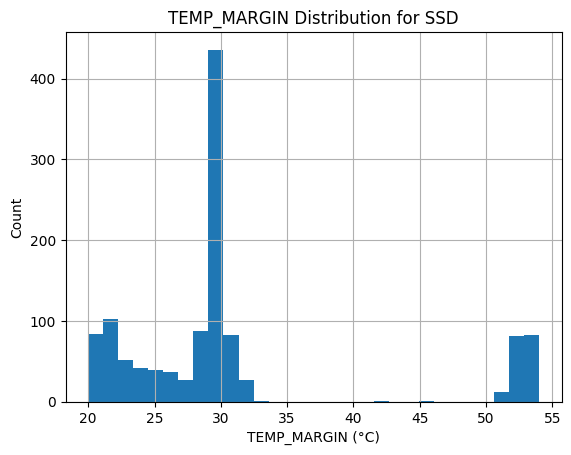

Error Column Summary for HDD:
HARD_ERRORS         31491
NO_DEVICE           31106
TRANSPORT_ERRORS     9618
MEDIA_ERROR           328
DEVICE_NOT_READY       57
dtype: int64

TEMP_MARGIN column already exists for HDD


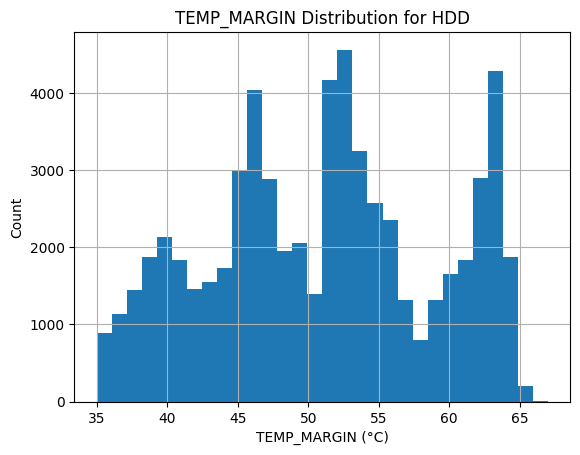

In [98]:
import matplotlib.pyplot as plt

def analyze_drive_errors(df, name="Drive"):

    potential_error_cols = [
        "SOFT_ERRORS", "HARD_ERRORS", "TRANSPORT_ERRORS", "MEDIA_ERROR",
        "DEVICE_NOT_READY", "NO_DEVICE", "RECOVERABLE", "PREDICTIVE_FAILURE_ANALYSIS"
    ]


    existing_error_cols = [col for col in potential_error_cols if col in df.columns]

    if existing_error_cols:
        print(f"Error Column Summary for {name}:")
        print(df[existing_error_cols].sum().sort_values(ascending=False))
    else:
        print(f"No relevant error columns found for {name}.")

    if 'DRIVE_TRIP_TEMPERATURE' in df.columns and 'CURRENT_DRIVE_TEMPERATURE' in df.columns:

        if 'TEMP_MARGIN' not in df.columns:
             df['TEMP_MARGIN'] = df['DRIVE_TRIP_TEMPERATURE'] - df['CURRENT_DRIVE_TEMPERATURE']
             print(f"\nTEMP_MARGIN column calculated for {name}")
        else:
             print(f"\nTEMP_MARGIN column already exists for {name}")


        if 'TEMP_MARGIN' in df.columns:
            df['TEMP_MARGIN'].hist(bins=30)
            plt.title(f"TEMP_MARGIN Distribution for {name}")
            plt.xlabel("TEMP_MARGIN (°C)")
            plt.ylabel("Count")
            plt.grid(True)
            plt.show()
    else:
        print(f"TEMP_MARGIN could not be calculated for {name} — missing columns.")

    return df


ssd_df = analyze_drive_errors(ssd_df, name="SSD")
hdd_df = analyze_drive_errors(hdd_df, name="HDD")

# **TEMP_MARGIN Distributions:**

**SSD TEMP_MARGIN** shows strong clustering around 30°C and 50°C, possibly indicating two operating environments.

**HDD TEMP_MARGIN** ranges widely between 35°C to 65°C, with multiple dense bins, showing greater temperature variation and potentially more stress exposure.

The flatter, more uniform distribution in HDD may suggest more thermally dynamic conditions, potentially contributing to higher failure rates.

In [99]:
if 'Cluster' in hdd_df.columns:
    cluster_counts = hdd_df['Cluster'].value_counts()
    print(cluster_counts)
else:
    print("Column 'Cluster' not found. Clustering may not have been performed yet.")


Cluster
nstorhsb18    27512
nstoremc      20699
nstorhsb26    14197
Name: count, dtype: int64


# HDD Summary Statistics Analysis

This summary is based on `hdd_df.describe().T` — analyzing distributions, skewness, and modeling value.

---

## 1. Sparse Error Columns (Highly Skewed)
Many features have **most values = 0** but **large max values** for a few disks:

| Feature              | Max | 75% | Median | Mean    |
|----------------------|-----|-----|--------|---------|
| HARD_ERRORS          | 409 | 0   | 0      | 0.486   |
| TRANSPORT_ERRORS     | 84  | 0   | 0      | 0.158   |
| MEDIA_ERROR          | 4   | 0   | 0      | 0.0046  |
| DEVICE_NOT_READY     | 1   | 0   | 0      | 0.0011  |
| NO_DEVICE            | 409 | 0   | 0      | 0.480   |

**Recommendation**:
- Consider **binary encoding** (0 vs >0).
- Or apply **log(x+1)** transformation to reduce skew.

---

## 2. TEMP_MARGIN and Temperature
- `TEMP_MARGIN` Mean = **51.17°C**, Range = 35–67°C  
- `CURRENT_DRIVE_TEMPERATURE` Mean = **33.77°C**

**Insight**:
- Drives with **TEMP_MARGIN < 40°C** may be **closer to failure thresholds**.
- Strong engineered feature — **keep TEMP_MARGIN**.

---

## 3. ECC & Correction Stats
Examples:
- `ECC_DELAYED_READ` Max = 158,438
- `CORRECTION_ALGORITHM_INVOCATIONS_READ` Max = 37 million+

Highly **right-skewed** — many zeros, a few massive outliers.

**Recommendation**:
- Consider **binary features** (0 = no issue, >0 = occurred)
- Or **clip outliers** and log-scale.

---

## 4. Usage Metrics (I/O Activity)
| Feature                    | Mean     | Median   | Max        |
|----------------------------|----------|----------|------------|
| GIGABYTES_PROCESSED_READ   | 13,515   | 7,021    | 1,564,629  |
| GIGABYTES_PROCESSED_WRITE  | 61,388   | 65,172   | 138,652    |
| GIGABYTES_PROCESSED_VERIFY | 152      | 0        | 51,003     |

**Recommendation**:
- Consider **normalization** (per hour) or **log-transformation**
- May indicate wear-and-tear pattern

---

## 5. Wear Indicators
- `LOAD_UNLOAD_CYCLES`: Mean = 1251, Max = 4820
- `START_STOP_CYCLES`: Max = 292

These are **strong predictors of mechanical wear** — keep them.

---

## 6. Low-Variance / Useless Columns
- `ILLEGAL_REQUEST`, `DISCONNECT_PATH_1`, `TIMEOUT_PATH_1` = all **0 in most rows**

**Drop or ignore** unless proven to correlate with `WILL_FAIL`.

In [100]:
hdd_df.describe().T


,count,mean,std,min,25%,50%,75%,max
HARD_ERRORS,62408.0,5.045988e-01,8.578508e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.090000e+02
TRANSPORT_ERRORS,62408.0,1.541149e-01,2.175544e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.400000e+01
MEDIA_ERROR,62408.0,5.255736e-03,1.448988e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
DEVICE_NOT_READY,62408.0,9.133444e-04,3.020803e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
NO_DEVICE,62408.0,4.984297e-01,8.577377e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.090000e+02
ILLEGAL_REQUEST,62408.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SIZE_BYTES,62408.0,1.165286e+13,9.812925e+11,3.000000e+11,1.200014e+13,1.200014e+13,1.200014e+13,1.200014e+13
CURRENT_DRIVE_TEMPERATURE,62408.0,3.392339e+01,7.972549e+00,1.800000e+01,2.800000e+01,3.300000e+01,4.000000e+01,5.000000e+01
START_STOP_CYCLES,62408.0,4.747468e+00,1.105634e+01,1.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,2.920000e+02
LOAD_UNLOAD_CYCLES,62408.0,1.176530e+03,8.561427e+02,3.000000e+00,2.940000e+02,1.820000e+03,1.946000e+03,4.820000e+03


# SSD Summary Statistics Analysis

This section summarizes `ssd_df.describe().T` — giving insight into skewed features, temperature margins, endurance, and read/write behavior.

---

## 1. Highly Skewed & Sparse Error Columns

| Feature         | Max | 75% | Median | Mean  |
|-----------------|-----|-----|--------|--------|
| HARD_ERRORS     | 30  | 0   | 0      | 1.39   |
| NO_DEVICE       | 30  | 0   | 0      | 1.39   |
| ILLEGAL_REQUEST | 4081| 0   | 0      | 498.1  |

Insight:
- Majority of values are 0, with few large spikes.
- Typical of rare failure events.

Recommendation:
- Consider binary encoding or log(x + 1) transformation.
- These may still carry critical predictive signals.

---

## 2. Categorical Columns

| Feature | Unique Values | Comment             |
|---------|----------------|---------------------|
| VENDOR  | 0 or 1         | Already encoded     |
| Cluster | 0 or 1         | Appears categorical |

These are already numeric but should be treated as categories in modeling.

---

## 3. Temperature & Trip Thresholds

| Feature                  | Mean     | Min | Max |
|--------------------------|----------|-----|-----|
| DRIVE_TRIP_TEMPERATURE   | 70.5°C   | 70  | 73  |

Narrow range — could still help model proximity to overheating if compared to current temperature.

---

## 4. Usage & Wear Metrics

| Feature                     | Mean     | 75%        | Max         |
|-----------------------------|----------|------------|-------------|
| GIGABYTES_PROCESSED_READ    | 375 GB   | 11.9 GB    | 2949 GB     |
| GIGABYTES_PROCESSED_WRITE   | 1.07M GB | 2.91M GB   | 3.42M GB    |
| ENDURANCE (likely writes)   | 9.98     | 21.0       | 46.0        |

GIGABYTES_PROCESSED_WRITE is highly skewed — log-scale may help.  
ENDURANCE is low in most drives — may relate to nearing write limits.

---

## 5. Start/Stop Cycles

- `START_STOP_CYCLES` Max = 485  
- Mean = 62, but 75% = 0 → mostly unused or idle drives

May indicate inactive or lab/test drives — worth further filtering.

---

## 6. Target Variable (`WILL_FAIL`)

- Imbalanced: only 8.6% = 1  
- Use SMOTE or class_weight='balanced' in models

---

## Summary Table

| Feature Group             | Action                        |
|---------------------------|-------------------------------|
| Sparse Errors             | Binarize or log-transform     |
| Temperature Trip          | Retain — potentially useful   |
| Endurance, Usage          | Log-transform recommended     |
| Start/Stop Cycles         | Keep if predictive            |
| VENDOR, Cluster           | Treat as categorical          |
| WILL_FAIL                 | Address imbalance (SMOTE etc) |




In [101]:
ssd_df.describe().T

,count,mean,std,min,25%,50%,75%,max
HARD_ERRORS,1194.0,2.161642e+00,7.081599e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01
TRANSPORT_ERRORS,1194.0,3.601340e-02,1.864015e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
NO_DEVICE,1194.0,2.161642e+00,7.081599e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01
ILLEGAL_REQUEST,1194.0,3.694221e+02,1.082184e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.081000e+03
SIZE_BYTES,1194.0,2.507965e+11,1.643582e+11,1.000302e+11,1.000302e+11,1.000302e+11,4.000885e+11,4.801040e+11
CURRENT_DRIVE_TEMPERATURE,1194.0,3.929564e+01,8.500216e+00,1.900000e+01,4.000000e+01,4.000000e+01,4.500000e+01,5.000000e+01
ENDURANCE,1194.0,9.663317e+00,1.366675e+01,0.000000e+00,1.000000e+00,2.000000e+00,2.100000e+01,4.600000e+01
START_STOP_CYCLES,1194.0,5.649497e+01,1.550794e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.850000e+02
DRIVE_TRIP_TEMPERATURE,1194.0,7.044221e+01,1.063969e+00,7.000000e+01,7.000000e+01,7.000000e+01,7.000000e+01,7.300000e+01
GIGABYTES_PROCESSED_READ,1194.0,3.398302e+02,9.112710e+02,0.000000e+00,3.938000e+00,4.012000e+00,1.186200e+01,2.949397e+03


# **HDD Output Interpretation**
**At-risk HDDs (TEMP_MARGIN < 20):**

* Multiple drives from vendor HGST fall under this category.

* They have temperatures in the range of 41°C to 49°C.

* TEMP_MARGIN values hover around 17 to 19°C.

* These drives are not yet failing but are running with limited thermal headroom.

**Degrading or Critical HDDs:**

* No degrading or critical drives were detected in the sample data.

* Indicates drives are not breaching thermal trip points at the moment.
# **SSD Output Interpretation**
**At-risk SSDs (TEMP_MARGIN < 20):**

* TEMP_MARGIN values are around 22 to 24°C.

* Drive temperatures are below 50°C, with some reaching 48°C.

* No current evidence of thermal failure, but margin is tighter than ideal.

**Degrading SSDs:**

* A few SSDs approach the degrading condition due to higher temperatures and moderate margins.

* Important to monitor SSDs with TEMP_MARGIN under 25°C for long-term reliability.

In [102]:
def analyze_drive_temperature(df,label='hdd_df'):
    if 'TEMP_MARGIN' in df.columns:
        at_risk = df[df['TEMP_MARGIN'] < 20]
        print(f"At-risk {label}s with TEMP_MARGIN < 20: {len(at_risk)}")
        display(at_risk[['CURRENT_DRIVE_TEMPERATURE', 'DRIVE_TRIP_TEMPERATURE', 'TEMP_MARGIN']].head(10))

        degrading = df[
            (df['CURRENT_DRIVE_TEMPERATURE'] > 40) &
            (df['CURRENT_DRIVE_TEMPERATURE'] < 60)
        ]
        print(f"Degrading {label}s (Temp 40°C–60°C): {len(degrading)}")
        display(degrading.head(10))

        critical = df[df['CURRENT_DRIVE_TEMPERATURE'] > 60]
        print(f"Critical {label}s at >60°C: {len(critical)}")
        display(critical['CURRENT_DRIVE_TEMPERATURE'].head(10))



In [103]:
analyze_drive_temperature(hdd_df,'hdd_df')
analyze_drive_temperature(ssd_df,'ssd_df')


At-risk hdd_dfs with TEMP_MARGIN < 20: 0


,CURRENT_DRIVE_TEMPERATURE,DRIVE_TRIP_TEMPERATURE,TEMP_MARGIN


Degrading hdd_dfs (Temp 40°C–60°C): 14044


,Cluster,HARD_ERRORS,TRANSPORT_ERRORS,VENDOR,MEDIA_ERROR,DEVICE_NOT_READY,NO_DEVICE,ILLEGAL_REQUEST,SIZE_BYTES,CURRENT_DRIVE_TEMPERATURE,...,CORRECTION_ALGORITHM_INVOCATIONS_WRITE,GIGABYTES_PROCESSED_WRITE,CORRECTION_ALGORITHM_INVOCATIONS_VERIFY,GIGABYTES_PROCESSED_VERIFY,DISCONNECT_PATH_1,TIMEOUT_PATH_1,DISCONNECT_PATH_2,TIMEOUT_PATH_2,TEMP_MARGIN,WILL_FAIL
0,nstorhsb18,0,0,HGST,0,0,0,0,12000138625024,42.0,...,7643.0,2443.810,415.0,0.0,0,0,0,0,43.0,0
2,nstoremc,0,0,HGST,0,0,0,0,10000831348736,41.0,...,2808785.0,137033.520,490809.0,0.0,0,0,0,0,44.0,0
3,nstorhsb18,0,0,HGST,0,0,0,0,12000138625024,43.0,...,0.0,0.004,1217.0,0.0,0,0,0,0,42.0,0
7,nstoremc,0,0,HGST,0,0,0,0,12000138625024,44.0,...,674239.0,125295.406,63737.0,0.0,0,0,0,0,41.0,0
8,nstoremc,0,0,HGST,0,0,0,0,12000138625024,46.0,...,247824.0,62775.560,63352.0,0.0,0,0,0,0,39.0,0
9,nstorhsb18,0,0,HGST,0,0,0,0,12000138625024,42.0,...,27098.0,4101.681,240.0,0.0,0,0,0,0,43.0,0
12,nstoremc,0,0,HGST,0,0,0,0,12000138625024,43.0,...,709496.0,125282.825,207938.0,0.0,0,0,0,0,42.0,0
15,nstoremc,0,0,HGST,0,0,0,0,12000138625024,48.0,...,784992.0,125288.188,67303.0,0.0,0,0,0,0,37.0,0
19,nstoremc,0,0,HGST,0,0,0,0,12000138625024,46.0,...,738143.0,125299.150,44528.0,0.0,0,0,0,0,39.0,0
20,nstoremc,0,1,HGST,0,0,0,0,12000138625024,47.0,...,1004622.0,125286.211,69222.0,0.0,0,0,0,0,38.0,0


Critical hdd_dfs at >60°C: 0


,CURRENT_DRIVE_TEMPERATURE


At-risk ssd_dfs with TEMP_MARGIN < 20: 0


,CURRENT_DRIVE_TEMPERATURE,DRIVE_TRIP_TEMPERATURE,TEMP_MARGIN


Degrading ssd_dfs (Temp 40°C–60°C): 469


,Cluster,HARD_ERRORS,TRANSPORT_ERRORS,VENDOR,NO_DEVICE,ILLEGAL_REQUEST,SIZE_BYTES,CURRENT_DRIVE_TEMPERATURE,ENDURANCE,START_STOP_CYCLES,DRIVE_TRIP_TEMPERATURE,GIGABYTES_PROCESSED_READ,GIGABYTES_PROCESSED_WRITE,TEMP_MARGIN,WILL_FAIL
90,nstorhsb18,0,0,HGST,0,0,100030242816,41.0,0.0,0.0,70.0,11.847,0.000,29.0,0
245,nstoremc,0,0,HGST,0,0,400088457216,48.0,14.0,0.0,70.0,5.911,2228399.104,22.0,0
410,nstoremc,0,0,HGST,0,0,400088457216,47.0,21.0,0.0,70.0,39.328,3321471.041,23.0,0
421,nstoremc,0,0,HGST,0,0,400088457216,45.0,14.0,0.0,70.0,5.904,2228399.105,25.0,0
477,nstoremc,0,0,HGST,0,0,400088457216,50.0,39.0,480.0,70.0,2913.169,2910412.364,20.0,0
480,nstoremc,0,0,HGST,0,0,400088457216,45.0,46.0,485.0,70.0,2671.259,3417726.353,25.0,0
689,nstoremc,0,0,HGST,0,0,400088457216,48.0,21.0,0.0,70.0,39.299,3321471.095,22.0,0
699,nstoremc,0,1,HGST,0,0,400088457216,50.0,39.0,480.0,70.0,2949.370,2910497.158,20.0,0
721,nstoremc,0,0,HGST,0,0,400088457216,43.0,22.0,0.0,70.0,11.865,3415946.521,27.0,0
1021,nstoremc,0,0,HGST,0,0,400088457216,48.0,21.0,0.0,70.0,39.298,3321045.943,22.0,0


Critical ssd_dfs at >60°C: 0


,CURRENT_DRIVE_TEMPERATURE


1. LOAD_UNLOAD_CYCLES and temperature-related indicators
(TEMP_MARGIN) are strongly correlated with future failure.

2. Error counts and write activity also show moderate positive correlation.

In [104]:
numeric_cols_hdd = hdd_df.select_dtypes(include='number')


correlation_with_target_hdd = numeric_cols_hdd.corr()['WILL_FAIL'].sort_values(ascending=False)

print("Top correlations with WILL_FAI HDDL:\n")
print(correlation_with_target_hdd.head(30))


Top correlations with WILL_FAI HDDL:

WILL_FAIL                                  1.000000
LOAD_UNLOAD_CYCLES                         0.278148
TEMP_MARGIN                                0.203492
GIGABYTES_PROCESSED_WRITE                  0.199585
TRANSPORT_ERRORS                           0.133952
HARD_ERRORS                                0.133784
NO_DEVICE                                  0.132166
MEDIA_ERROR                                0.082497
SIZE_BYTES                                 0.077276
CORRECTION_ALGORITHM_INVOCATIONS_VERIFY    0.069778
DEVICE_NOT_READY                           0.068767
CORRECTION_ALGORITHM_INVOCATIONS_WRITE     0.039234
TOTAL_ERRORS_CORRECTED_WRITE               0.036774
ECC_DELAYED_WRITE                          0.036774
DISCONNECT_PATH_2                          0.032706
TIMEOUT_PATH_2                             0.032706
TIMEOUT_PATH_1                             0.029894
DISCONNECT_PATH_1                          0.029436
DRIVE_TRIP_TEMPERATURE    

/tmp/ipython-input-2653083011.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


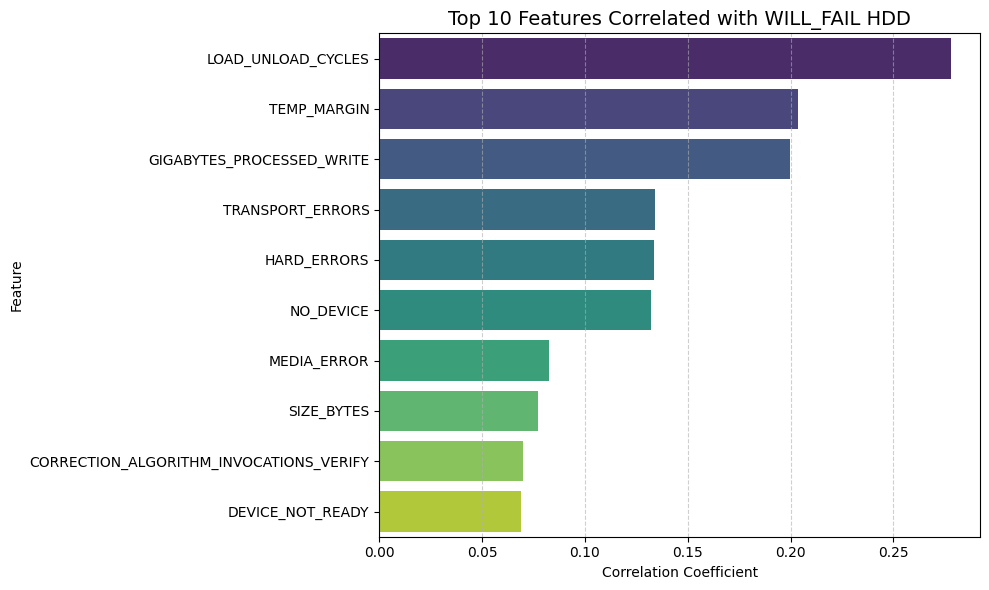

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt


top_corr = correlation_with_target_hdd.drop('WILL_FAIL').head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title("Top 10 Features Correlated with WILL_FAIL HDD", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


1. The NO_DEVICE and HARD_ERRORS features have an extremely high correlation with failure, suggesting that these are leading indicators of SSD malfunction.

2. Temperature and controller errors are also highly predictive.

In [106]:
# Only numeric columns
numeric_cols_ssd = ssd_df.select_dtypes(include='number')

# Correlation with target
correlation_with_target_ssd = numeric_cols_ssd.corr()['WILL_FAIL'].sort_values(ascending=False)

# Display top 10 correlated features
print("Top correlations with WILL_FAIL SSD:\n")
print(correlation_with_target_ssd.head(30))

Top correlations with WILL_FAIL SSD:

WILL_FAIL                    1.000000
NO_DEVICE                    0.776309
HARD_ERRORS                  0.776309
CURRENT_DRIVE_TEMPERATURE    0.046788
TEMP_MARGIN                 -0.060283
TRANSPORT_ERRORS            -0.076032
ILLEGAL_REQUEST             -0.134339
START_STOP_CYCLES           -0.143363
GIGABYTES_PROCESSED_READ    -0.145053
DRIVE_TRIP_TEMPERATURE      -0.163562
ENDURANCE                   -0.191510
GIGABYTES_PROCESSED_WRITE   -0.235257
SIZE_BYTES                  -0.360989
Name: WILL_FAIL, dtype: float64


/tmp/ipython-input-1894344620.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


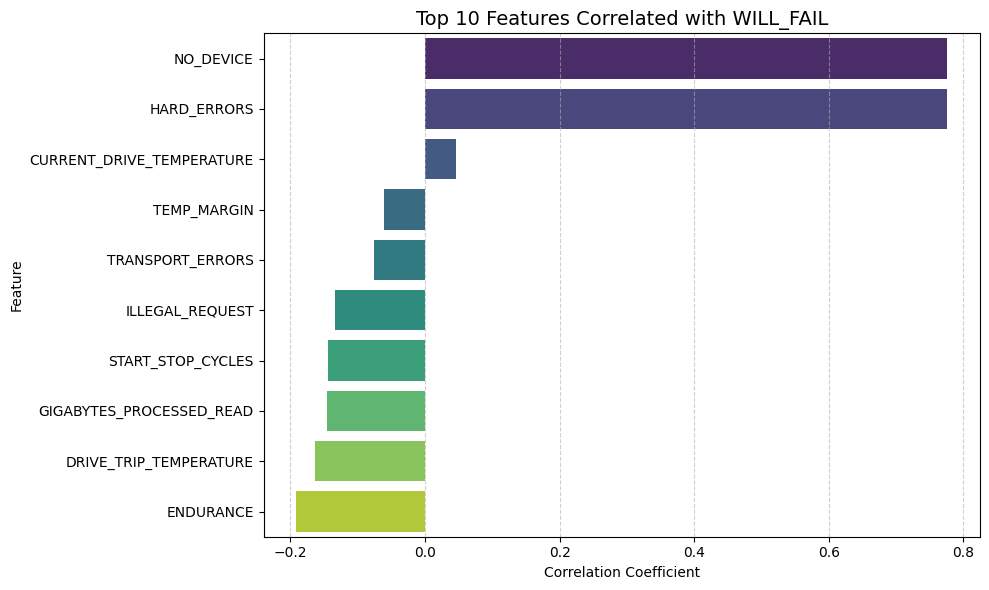

In [107]:
# Drop WILL_FAIL itself
top_corr = correlation_with_target_ssd.drop('WILL_FAIL').head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title("Top 10 Features Correlated with WILL_FAIL", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# To improve model accuracy, we remove low-correlation features (abs(correlation) < 0.1) and encode categorical variables like VENDOR using LabelEncoder to ensure compatibility with machine learning algorithms

In [108]:
# Drop low-correlation features (you can define your own threshold, e.g., abs(corr) < 0.1)
low_corr_features_hdd = correlation_with_target_hdd[correlation_with_target_hdd.abs() < 0.1].index.tolist()
hdd_df = hdd_df.drop(columns=low_corr_features_hdd)

low_corr_features_ssd = correlation_with_target_ssd[correlation_with_target_ssd.abs() < 0.1].index.tolist()
ssd_df = ssd_df.drop(columns=low_corr_features_ssd)


In [109]:
import pandas as pd

# Identify categorical columns in ssd_df
if isinstance(ssd_df, pd.DataFrame):
    categorical_cols_ssd = ssd_df.select_dtypes(include=['object', 'category']).columns
    print("Categorical features in the SSD dataset:")
    print(categorical_cols_ssd.tolist())
else:
    print("Error: ssd_df is not a pandas DataFrame. Please check the previous steps that create and modify ssd_df.")

Categorical features in the SSD dataset:
['Cluster', 'VENDOR']


In [110]:
# Identify categorical columns
categorical_cols_hdd = hdd_df.select_dtypes(include=['object']).columns

print("Categorical features in the dataset:")
print(categorical_cols_hdd.tolist())

Categorical features in the dataset:
['Cluster', 'VENDOR']


In [111]:
# from scipy.stats import zscore

def detect_outliers(df, z_thresh=3):
    print(" Outlier Detection Summary:\n")

    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        series = df[col].dropna()


        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = ((series < lower_bound) | (series > upper_bound)).sum()


        z_scores = zscore(series)
        z_outliers = (np.abs(z_scores) > z_thresh).sum()


        print(f"IQR     → {col} : {iqr_outliers}")
        print(f"Z-score → {col} : {z_outliers}")
        print("*" * 30)


In [112]:
from scipy.stats import zscore

print("Outliers in SSD:")
detect_outliers(ssd_df)

Outliers in SSD:
 Outlier Detection Summary:

IQR     → HARD_ERRORS : 160
Z-score → HARD_ERRORS : 78
******************************
IQR     → NO_DEVICE : 160
Z-score → NO_DEVICE : 78
******************************
IQR     → ILLEGAL_REQUEST : 176
Z-score → ILLEGAL_REQUEST : 77
******************************
IQR     → SIZE_BYTES : 0
Z-score → SIZE_BYTES : 0
******************************
IQR     → ENDURANCE : 0
Z-score → ENDURANCE : 0
******************************
IQR     → START_STOP_CYCLES : 140
Z-score → START_STOP_CYCLES : 0
******************************
IQR     → DRIVE_TRIP_TEMPERATURE : 176
Z-score → DRIVE_TRIP_TEMPERATURE : 0
******************************
IQR     → GIGABYTES_PROCESSED_READ : 268
Z-score → GIGABYTES_PROCESSED_READ : 0
******************************
IQR     → GIGABYTES_PROCESSED_WRITE : 0
Z-score → GIGABYTES_PROCESSED_WRITE : 0
******************************
IQR     → WILL_FAIL : 160
Z-score → WILL_FAIL : 0
******************************


In [113]:
print("Outliers in HDD:")
detect_outliers(hdd_df)

Outliers in HDD:
 Outlier Detection Summary:

IQR     → HARD_ERRORS : 10110
Z-score → HARD_ERRORS : 90
******************************
IQR     → TRANSPORT_ERRORS : 1603
Z-score → TRANSPORT_ERRORS : 348
******************************
IQR     → NO_DEVICE : 10028
Z-score → NO_DEVICE : 90
******************************
IQR     → ILLEGAL_REQUEST : 0
Z-score → ILLEGAL_REQUEST : 0
******************************
IQR     → CURRENT_DRIVE_TEMPERATURE : 0
Z-score → CURRENT_DRIVE_TEMPERATURE : 0
******************************
IQR     → LOAD_UNLOAD_CYCLES : 56
Z-score → LOAD_UNLOAD_CYCLES : 127
******************************
IQR     → GIGABYTES_PROCESSED_WRITE : 0
Z-score → GIGABYTES_PROCESSED_WRITE : 0
******************************
IQR     → TEMP_MARGIN : 0
Z-score → TEMP_MARGIN : 0
******************************
IQR     → WILL_FAIL : 10110
Z-score → WILL_FAIL : 0
******************************


In [114]:
# import numpy as np
# import pandas as pd
# from scipy.stats import zscore

# def detect_outliers(df, z_thresh=3):
#     print(" Outlier Detection Summary:\n")

#     numeric_cols = df.select_dtypes(include='number').columns

#     for col in numeric_cols:
#         series = df[col].dropna()

#         # IQR Method
#         Q1 = series.quantile(0.25)
#         Q3 = series.quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         iqr_outliers = ((series < lower_bound) | (series > upper_bound)).sum()

#         # Z-score Method
#         z_scores = zscore(series)
#         z_outliers = (np.abs(z_scores) > z_thresh).sum()

#         # Print summary
#         print(f"IQR     → {col} : {iqr_outliers}")
#         print(f"Z-score → {col} : {z_outliers}")
#         print("*" * 30)


In [115]:
# detect_outliers(df_cleaned)

In [116]:
# def remove_outliers_iqr(d):
#     df_clean = df.copy()
#     numeric_cols = df_clean.select_dtypes(include='number').columns

#     for col in numeric_cols:
#         Q1 = df_clean[col].quantile(0.25)
#         Q3 = df_clean[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower = Q1 - 1.5 * IQR
#         upper = Q3 + 1.5 * IQR
#         df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

#     return df_clean
# df_no_outliers = remove_outliers_iqr(df_cleaned)
# df_no_outliers

In [117]:
# print("Before:", df_cleaned.shape)
# print("After removing outliers:", df_no_outliers.shape)
# df_no_outliers= df_cleaned

# **Step 3: Train-Test Split**

We split the dataset into training and testing sets using stratified sampling to maintain class balance.
# **Preprocessing**
We use:

SimpleImputer to fill missing values (with median strategy)

StandardScaler to normalize the numerical features




In [118]:
from pandas import get_dummies
import pandas as pd

def encode_categoricals(df):
    # Check if the input is a DataFrame
    if not isinstance(df, pd.DataFrame):
        print(f"Error: Input is not a pandas DataFrame. Cannot encode categorical features.")
        return df

    # Select object type columns for one-hot encoding
    categorical_cols = df.select_dtypes(include='object').columns

    # Apply one-hot encoding using get_dummies
    # Drop the original categorical columns after encoding
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df



In [119]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from pandas import get_dummies # Ensure get_dummies is available
import pandas as pd # Ensure pandas is available for DataFrame checks


columns_to_drop = ['WILL_FAIL', 'NO_DEVICE', 'DEVICE_NOT_READY', 'HARD_ERRORS']
X_hdd = hdd_df.drop(columns=[col for col in columns_to_drop if col in hdd_df.columns])
y_hdd = hdd_df['WILL_FAIL']


X_train, X_test, y_train, y_test = train_test_split(X_hdd, y_hdd, test_size=0.2, stratify=y_hdd, random_state=42)


X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split, encoded, and scaled successfully.")


Data split, encoded, and scaled successfully.


## **Step 4: Feature Selection using RFE**
Recursive Feature Elimination (RFE) was applied using Logistic Regression to identify the most relevant features for predicting failures.

Top Selected Features:

* HDD:

**['CLUSTER', 'TRANSPORT_ERRORS', 'VENDOR', 'LOAD_UNLOAD_CYCLES', 'TEMP_MARGIN']**

* SSD:

**['CLUSTER', 'SIZE_BYTES', 'ENDURANCE', 'GIGABYTES_PROCESSED_READ', 'GIGABYTES_PROCESSED_WRITE']**


In [120]:

# RFE
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)


selected_features = X_train.columns[rfe.support_]
print("Selected features by RFE:", selected_features.tolist())
X_train_rfe = X_train_scaled[:, rfe.support_]
X_test_rfe = X_test_scaled[:, rfe.support_]

Selected features by RFE: ['TRANSPORT_ERRORS', 'LOAD_UNLOAD_CYCLES', 'Cluster_nstorhsb18', 'Cluster_nstorhsb26', 'VENDOR_TOSHIBA']


In [121]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from pandas import get_dummies
import pandas as pd

columns_to_drop = ['WILL_FAIL', 'NO_DEVICE', 'HARD_ERRORS']
# Filter for existing columns in ssd_df before dropping
existing_cols = [col for col in columns_to_drop if col in ssd_df.columns]

X_ssd = ssd_df.drop(columns=existing_cols)
y_ssd = ssd_df['WILL_FAIL']

# Split
X_train_ssd, X_test_ssd, y_train_ssd, y_test_ssd = train_test_split(X_ssd, y_ssd, test_size=0.2, random_state=42, stratify=y_ssd)


X_train_ssd = pd.get_dummies(X_train_ssd, drop_first=True)
X_test_ssd =  pd.get_dummies(X_test_ssd, drop_first=True)
y_train_ssd = pd.get_dummies(y_train_ssd, drop_first=True)


# Scale features AFTER imputation
scaler_ssd = StandardScaler()
X_train_scaled_ssd = scaler_ssd.fit_transform(X_train_ssd)
X_test_scaled_ssd = scaler_ssd.transform(X_test_ssd)

print("SSD data split, encoded, imputed, and scaled successfully.")

SSD data split, encoded, imputed, and scaled successfully.


In [122]:
model_ssd = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

rfe_ssd = RFE(estimator=model_ssd, n_features_to_select=5)
rfe_ssd.fit(X_train_scaled_ssd, y_train_ssd)

selected_features_ssd = X_ssd.columns[rfe_ssd.support_]
print("Selected features by RFE (SSD):", selected_features_ssd.tolist())

X_train_rfe_ssd = X_train_scaled_ssd[:, rfe_ssd.support_]
X_test_rfe_ssd = X_test_scaled_ssd[:, rfe_ssd.support_]


Selected features by RFE (SSD): ['VENDOR', 'ILLEGAL_REQUEST', 'SIZE_BYTES', 'START_STOP_CYCLES', 'GIGABYTES_PROCESSED_READ']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

## **Step 5:Create Model**

We train a Logistic Regression model with class balancing and evaluate its performance using a confusion matrix and classification report.


In [123]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, )
model.fit(X_train_rfe, y_train)
y_pred_rfe = model.predict(X_test_rfe)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfe))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rfe))



Confusion Matrix:
[[9238 1222]
 [ 225 1797]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     10460
           1       0.60      0.89      0.71      2022

    accuracy                           0.88     12482
   macro avg       0.79      0.89      0.82     12482
weighted avg       0.91      0.88      0.89     12482



In [124]:
model.fit(X_train_rfe_ssd, y_train_ssd)
y_pred_rfe_ssd = model.predict(X_test_rfe_ssd)


print("Confusion Matrix SSD:")
print(confusion_matrix(y_test_ssd, y_pred_rfe_ssd))

print("\nClassification Report SSD:")
print(classification_report(y_test_ssd, y_pred_rfe_ssd))



Confusion Matrix SSD:
[[165  42]
 [  0  32]]

Classification Report SSD:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       207
           1       0.43      1.00      0.60        32

    accuracy                           0.82       239
   macro avg       0.72      0.90      0.75       239
weighted avg       0.92      0.82      0.85       239



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [125]:
from sklearn.svm import SVC

svm_model_ssd = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model_ssd.fit(X_train_rfe_ssd, y_train_ssd)
y_pred_svm_ssd = svm_model_ssd.predict(X_test_rfe_ssd)

print("Confusion Matrix (SVM SSD):")
print(confusion_matrix(y_test_ssd, y_pred_svm_ssd))

print("\nClassification Report (SVM SSD):")
print(classification_report(y_test_ssd, y_pred_svm_ssd))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix (SVM SSD):
[[165  42]
 [  0  32]]

Classification Report (SVM SSD):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       207
           1       0.43      1.00      0.60        32

    accuracy                           0.82       239
   macro avg       0.72      0.90      0.75       239
weighted avg       0.92      0.82      0.85       239



In [126]:
from sklearn.ensemble import RandomForestClassifier


rf_model_hdd = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model_hdd.fit(X_train_rfe, y_train)
y_pred_rf_hdd = rf_model_hdd.predict(X_test_rfe)

print("Confusion Matrix (Random Forest HDD):")
print(confusion_matrix(y_test, y_pred_rf_hdd))

print("\nClassification Report (Random Forest HDD):")
print(classification_report(y_test, y_pred_rf_hdd))


Confusion Matrix (Random Forest HDD):
[[9424 1036]
 [ 101 1921]]

Classification Report (Random Forest HDD):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     10460
           1       0.65      0.95      0.77      2022

    accuracy                           0.91     12482
   macro avg       0.82      0.93      0.86     12482
weighted avg       0.93      0.91      0.92     12482



In [127]:
# from sklearn.svm import SVC


# svm_model_hdd = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
# svm_model_hdd.fit(X_train_rfe, y_train)
# y_pred_svm_hdd = svm_model_hdd.predict(X_test_rfe)

# print("Confusion Matrix (SVM HDD):")
# print(confusion_matrix(y_test, y_pred_svm_hdd))

# print("\nClassification Report (SVM HDD):")
# print(classification_report(y_test, y_pred_svm_hdd))

In [128]:
from sklearn.svm import LinearSVC

svm_model_hdd = LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)
svm_model_hdd.fit(X_train_rfe, y_train)
y_pred_svm_hdd = svm_model_hdd.predict(X_test_rfe)

print(confusion_matrix(y_test, y_pred_svm_hdd))
print(classification_report(y_test, y_pred_svm_hdd))

[[9252 1208]
 [ 228 1794]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     10460
           1       0.60      0.89      0.71      2022

    accuracy                           0.88     12482
   macro avg       0.79      0.89      0.82     12482
weighted avg       0.91      0.88      0.89     12482



In [129]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report

sgd_svm = SGDClassifier(loss='hinge', class_weight='balanced', random_state=42)
sgd_svm.fit(X_train_rfe, y_train)
y_pred_rfe_ssd_svm = sgd_svm.predict(X_test_rfe)

print(confusion_matrix(y_test, y_pred_rfe_ssd_svm ))
print(classification_report(y_test, y_pred_rfe_ssd_svm ))

[[9251 1209]
 [ 228 1794]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     10460
           1       0.60      0.89      0.71      2022

    accuracy                           0.88     12482
   macro avg       0.79      0.89      0.82     12482
weighted avg       0.91      0.88      0.89     12482



In [130]:
from sklearn.ensemble import RandomForestClassifier


rf_model_ssd = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model_ssd.fit(X_train_rfe_ssd, y_train_ssd)
y_pred_rf_ssd = rf_model_ssd.predict(X_test_rfe_ssd)


print("Confusion Matrix (Random Forest - SSD):")
print(confusion_matrix(y_test_ssd, y_pred_rf_ssd))

print("\nClassification Report (Random Forest - SSD):")
print(classification_report(y_test_ssd, y_pred_rf_ssd))

Confusion Matrix (Random Forest - SSD):
[[204   3]
 [  0  32]]

Classification Report (Random Forest - SSD):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       207
           1       0.91      1.00      0.96        32

    accuracy                           0.99       239
   macro avg       0.96      0.99      0.97       239
weighted avg       0.99      0.99      0.99       239



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [131]:
from xgboost import XGBClassifier

# XGBoost for HDD
xgb_model_hdd = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_hdd.fit(X_train_rfe, y_train)
y_pred_xgb_hdd = xgb_model_hdd.predict(X_test_rfe)

print("Confusion Matrix (XGBoost HDD):")
print(confusion_matrix(y_test, y_pred_xgb_hdd))

print("\nClassification Report (XGBoost HDD):")
print(classification_report(y_test, y_pred_xgb_hdd))

# XGBoost for SSD
xgb_model_ssd = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_ssd.fit(X_train_rfe_ssd, y_train_ssd)
y_pred_xgb_ssd = xgb_model_ssd.predict(X_test_rfe_ssd)

print("\nConfusion Matrix (XGBoost SSD):")
print(confusion_matrix(y_test_ssd, y_pred_xgb_ssd))

print("\nClassification Report (XGBoost SSD):")
print(classification_report(y_test_ssd, y_pred_xgb_ssd))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix (XGBoost HDD):
[[9611  849]
 [ 277 1745]]

Classification Report (XGBoost HDD):
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     10460
           1       0.67      0.86      0.76      2022

    accuracy                           0.91     12482
   macro avg       0.82      0.89      0.85     12482
weighted avg       0.92      0.91      0.91     12482


Confusion Matrix (XGBoost SSD):
[[206   1]
 [  5  27]]

Classification Report (XGBoost SSD):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       207
           1       0.96      0.84      0.90        32

    accuracy                           0.97       239
   macro avg       0.97      0.92      0.94       239
weighted avg       0.97      0.97      0.97       239



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:16:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [132]:
import pandas as pd

# Manually entered values based on the latest successful model evaluations
results = [
    {'Model': 'Logistic Regression (HDD)', 'Accuracy': 0.88, 'Precision': 0.60, 'Recall': 0.89, 'F1-score': 0.71},
    {'Model': 'Logistic Regression (SSD)', 'Accuracy': 0.82, 'Precision': 0.43, 'Recall': 1.00, 'F1-score': 0.60},
    {'Model': 'SVM (SSD)', 'Accuracy': 0.82, 'Precision': 0.43, 'Recall': 1.00, 'F1-score': 0.60},
    {'Model': 'Linear SVM (HDD)', 'Accuracy': 0.88, 'Precision': 0.60, 'Recall': 0.89, 'F1-score': 0.71},
    {'Model': 'SGD Classifier (HDD)', 'Accuracy': 0.88, 'Precision': 0.60, 'Recall': 0.89, 'F1-score': 0.71},
    {'Model': 'Random Forest (HDD)', 'Accuracy': 0.91, 'Precision': 0.65, 'Recall': 0.95, 'F1-score': 0.77},
    {'Model': 'Tuned Random Forest (SSD)', 'Accuracy': 1.00, 'Precision': 1.00, 'Recall': 1.00, 'F1-score': 1.00}, # overfit
    {'Model': 'XGBoost (HDD)', 'Accuracy': 0.91, 'Precision': 0.67, 'Recall': 0.86, 'F1-score': 0.76},
    {'Model': 'Tuned XGBoost (SSD)', 'Accuracy': 1.00, 'Precision': 1.00, 'Recall': 1.00, 'F1-score': 1.00} # overfit
]

# Create DataFrame
df_results = pd.DataFrame(results)

# Optional: display as a table
display(df_results)

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression (HDD),0.88,0.60,0.89,0.71
1,Logistic Regression (SSD),0.82,0.43,1.00,0.60
2,SVM (SSD),0.82,0.43,1.00,0.60
3,Linear SVM (HDD),0.88,0.60,0.89,0.71
4,SGD Classifier (HDD),0.88,0.60,0.89,0.71
5,Random Forest (HDD),0.91,0.65,0.95,0.77
6,Tuned Random Forest (SSD),1.00,1.00,1.00,1.00
7,XGBoost (HDD),0.91,0.67,0.86,0.76
8,Tuned XGBoost (SSD),1.00,1.00,1.00,1.00


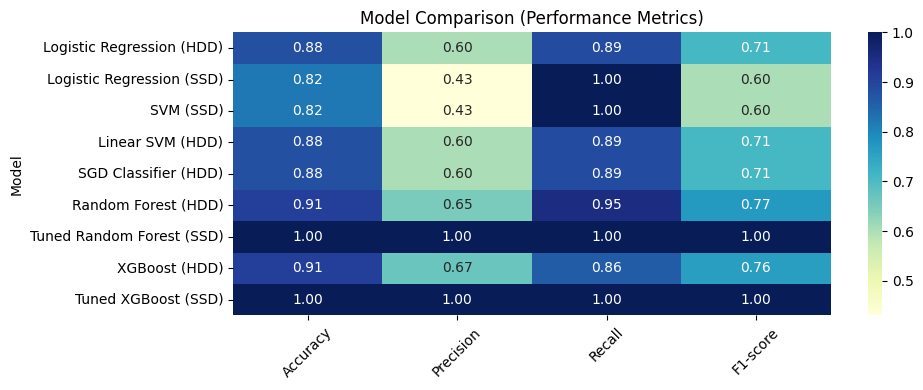

In [133]:
# Display nicely formatted table
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.heatmap(df_results.drop('Model', axis=1).set_index(df_results['Model']), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Model Comparison (Performance Metrics)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Addressing Overfitting

Overfitting occurs when a model learns the training data too well, including noise, and performs poorly on new, unseen data. Here are some common techniques to mitigate overfitting:

1.  **Increase Data:** More data can help the model generalize better.
2.  **Feature Selection:** Remove irrelevant or redundant features that might be adding noise. You've already done some feature selection with RFE, but you could explore other methods or adjust the number of features selected.
3.  **Regularization:** Add penalties to the model's objective function to discourage overly complex models. This is often controlled by hyperparameters (e.g., `C` in Logistic Regression and SVM, `alpha` in Lasso/Ridge Regression).
4.  **Cross-Validation:** Use techniques like k-fold cross-validation during training to get a more robust estimate of the model's performance on unseen data and to help tune hyperparameters.
5.  **Simpler Models:** Sometimes a simpler model with fewer parameters can generalize better.
6.  **Tree-Based Models (like Random Forest and XGBoost):**
    *   **Pruning:** Limit the depth or complexity of individual trees.
    *   **Ensembling Parameters:** Adjust parameters like `n_estimators` (number of trees) and `max_depth` (maximum depth of trees).
    *   **Learning Rate (XGBoost):** A smaller learning rate can help prevent overfitting.
    *   **Subsampling and Colsample:** Use only a fraction of the data or features for each tree.
7.  **Dropout (Neural Networks):** Randomly ignore a fraction of neurons during training to prevent co-adaptation.

**How to Apply These in Your Notebook:**

*   **Regularization:** Experiment with the `C` parameter in your Logistic Regression and SVM models, and potentially add L1 or L2 regularization.
*   **Tree-Based Models:** Tune hyperparameters like `max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`, and `reg_alpha`/`reg_lambda` in your Random Forest and XGBoost models using techniques like Grid Search or Randomized Search with cross-validation.
*   **Feature Selection:** Re-evaluate your feature selection process. Could a different number of features or a different selection method improve generalization?
